# TensorFlow Tutorial #04
# Save & Restore

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

이 튜토리얼은 신경망의 변수를 어떻게 저장하고 불러오는지를 보여준다. 최적화 동안 검증 데이터셋에 대한 분류 정확도가 향상될 때마다 신경망의 변수들을 저장한다. 이 최적화는 1000번 동안 향상되지 않으면 그만둔다. 검증 데이터셋에 최고의 성능을 보이는 변수들을 다시 불러온다.

이 전략은 Early Stopping이라 불린다. 이것은 신경망의 과적합을 막는데 사용된다. 신경망이 학습 데이터에 노이즈까지 학습할 정도로 너무 오래 학습하는 경우에 발생한다. 그래서 새로운 이미지에 대해 잘못 분류하게 될 수 있다.

과적합은 이 튜토리얼에서 사용하는 손글씨 숫자를 이해하기 위한 MNIST 데이터에 대한 신경망의 문제는 아니다. 하지만 이 튜토리얼은 Early Stopping의 아이디어를 보여준다.

이전 튜토리얼로부터 만들어진다. 그래서 텐서플로와 Pretty Tensor의 기본적 이해가 필요하다. 이 튜토리얼의 소스코드와 글들은 이전과 유사하다.

## Flowchart

아래의 그림은 콘볼루션 신경망의 데이터 흐름을 대략적으로 보여준다.

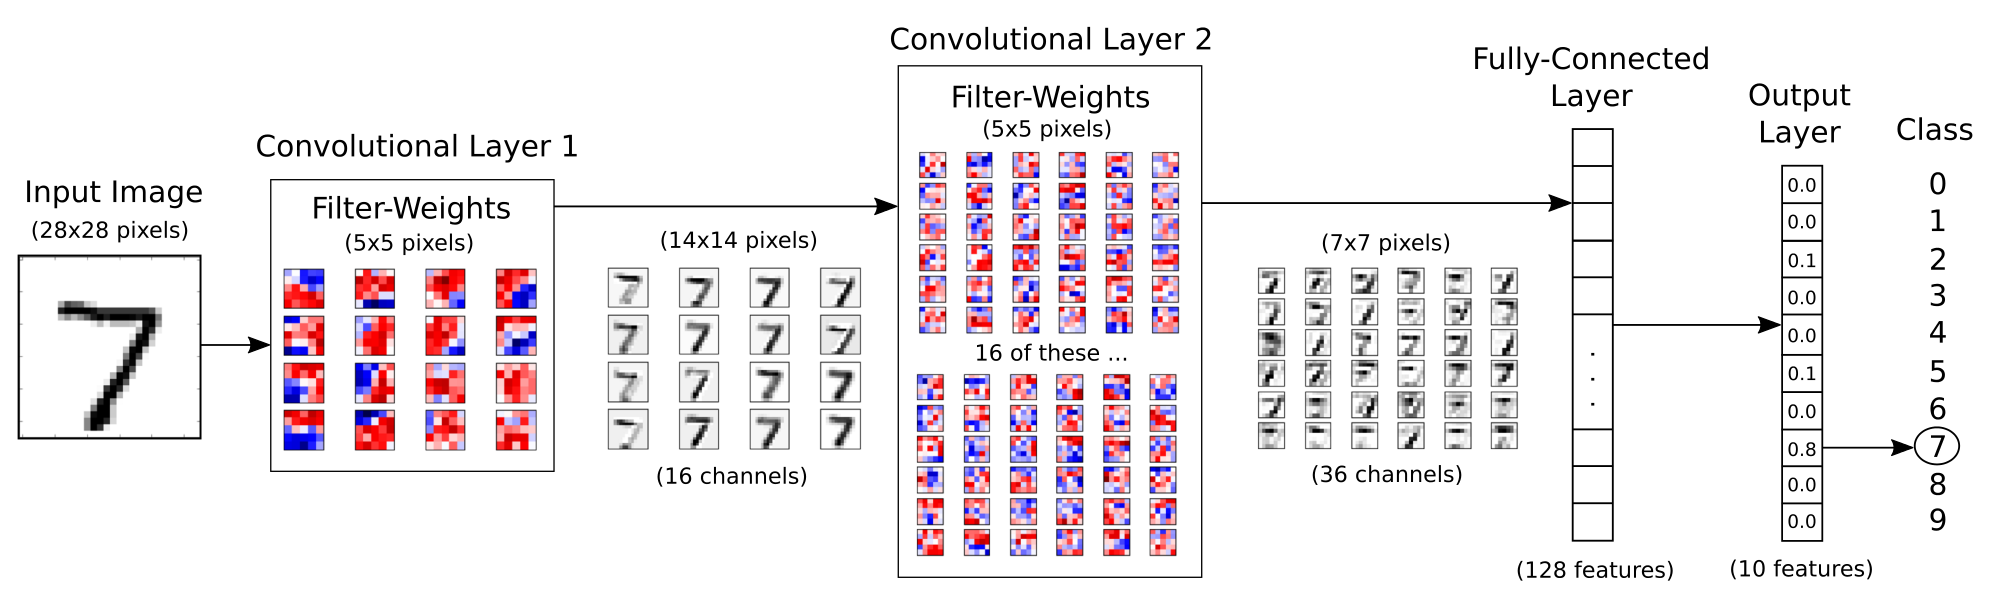

In [1]:
from IPython.display import Image
Image('images/02_network_flowchart.png')

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

파이썬 3.5.2 (아나콘다)와 텐서플로 1.0.1 버젼으로 함

In [3]:
tf.__version__

'1.0.1'

PrettyTensor version:

In [4]:
pt.__version__

'0.7.4'

## Load Data

MNIST 데이터셋은 약 12 MB 정도고, 주어진 경로에 없다면 자동으로 받아짐

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


MNIST 데이터셋은 70,000 장의 이미지와 라벨로 구성되어 있다. 
이 데이터셋은 상호 배타적인 3개로 나뉘어 있다. 
이 튜토리얼에서는 학습과 테스트만 사용할 것이다.

In [6]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


클래스 라벨들은 One-Hot encode 되어있다. 이것은 해당 라벨만 1이고 나머지는 0인 10의 길이를 갖는 벡터로 되어 있음을 의미한다. 우리는 또한 테스트 셋에 대한 비교를 위해 정수도 필요하다.

In [7]:
data.test.cls = np.argmax(data.test.labels, axis=1)
data.validation.cls = np.argmax(data.validation.labels, axis=1)

## Data Dimensions

데이터 차원은 아래 보이는 소스코드 여러군데에서 사용된다. 

컴퓨터프로그래밍에서 일반적으로 사용할 모든 숫자를 입력하는 하드코딩 보다는 변수나 상수를 사용하는 것이 최선이다. 

이것은 그 숫자들은 하나의 위치에서만 바꾸는 것을 의미한다. 

이상적으로 이것들은 자료에서 얻어질 것이지만, 여기서는 숫자들로 입력한다.

In [8]:
# MNIST 이미지의 각 차원은 28 픽셀이다
img_size = 28

# 이미지들은 1차원 벡터로 저장되어 있다
img_size_flat = img_size * img_size

# 높이와 너비를 갖는 튜플은 reshape 배열에 사용된다.
img_shape = (img_size, img_size)

# 이미지에 대한 색 채널의 수 : 흑백 채널은 1채널이다.
num_channels = 1

# 클래스의 숫자, 10개 숫자 각각이 하나의 클래스
num_classes = 10

### Helper-function for plotting images

3x3 격자에 9개의 이미지를 출력하고, 각 이미지에 대해 예측 클래스와 실제값을 보여주는 함수

In [9]:
# 3개의 인자를 받는다. (이미지, 실제 클래스값, 클래스 예측값)
def plot_images(images, cls_true, cls_pred=None):
    # 이미지의 길이와 cls_true의 값이 9가 맞는지 확인 아니면 에러
    assert len(images) == len(cls_true) == 9
    
    # subplots로 3x3 격자 figure를 만듬
    fig, axes = plt.subplots(3, 3)
    # 각 격자의 떨어진 정도를 조정함
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    # 각 격자의 순서대로 넣기 위해 enumerate를 사용
    for i, ax in enumerate(axes.flat):
        # 이미지를 각 순서대로 넣음
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # 실제값과 예측값을 보여줌
        # 예측 클래스 값들이 없으면
        if cls_pred is None:
            # 실제값만 나타냄
            xlabel = "True: {0}".format(cls_true[i])
        # 아니면
        else:
            # 둘다 나타냄
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        # x축 라벨 설정
        ax.set_xlabel(xlabel)
        
        # 눈금 지움
        ax.set_xticks([])
        ax.set_yticks([])

### Plot a few images to see if data is correct

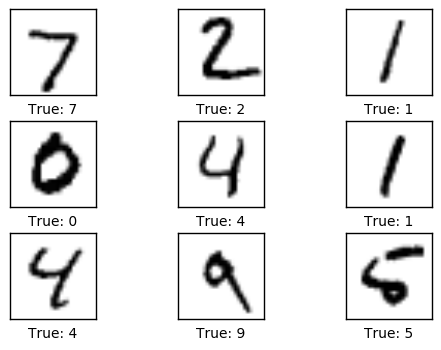

In [10]:
# 테스트셋에서 첫 9개 이미지 가져옴
images = data.test.images[0:9]

# 이들 이미지의 실제 클래스값 얻음
cls_true = data.test.cls[0:9]

# 위의 함수를 이용해 나타냄
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

텐서플로의 목적은 파이썬에서 같은 연산을 실행하는 것보다 효율적으로 실행할 수 있는 계산 그래프(computational graph)를 갖는 것이다. 텐서플로는 넘파이가 매 순간 하나의 수식 연산만 아는 것과는 달리 실행될 때에 모든 계산 그래프를 알고 있어야하기 때문에 더 효율적이다.

텐서플로는 모델이 더 나은 성능을 내기 위해서 그래프의 변수들을 최적화하기 위해 필요한 그라디언트를 자동으로 계산할 수 있다. 이 그래프가 하나의 수식 연산의 결합이기 때문에 체인룰을 이용해 전체 그래프의 그라디언트를 계산할 수 있다.

텐서플로는 또한 멀티코어 CPU 이점도 있다.

텐서플로 그래프는 아래의 파트로 구성된다:
- Placeholder 변수는 그래프의 입력을 바꿀 때 사용
- Model 변수는 최적화될 변수
- 모델은 placeholder 변수와 model 변수들이 주어질 때 출력을 계산하는 수학 함수
- 비용은 변수의 최적화에 사용
- 최적화방법은 모델의 변수를 업데이트 하는 것

게다가, 텐서플로 그래프는 이 튜토리얼에서 다루지는 않지만, 텐서보드를 사용해 보기위한 로그를 남기기 위한 다양한 디버깅 스테이트먼트를 포함할 수 있다. 

### Placeholder variables

Placeholder 변수는 그래프를 실행할 때 바뀔 수도 있는 그래프에 입력값을 보낸다.
아래에서 시연한다.

첫째, 입력 이미지에 대한 placeholder 변수를 정의한다. 텐서 그래프에 입력으로 변할 수 잇는 이미지를 보낸다. 이것이 다차원 벡터 혹은 행렬을 의미하는 텐서다. 데이터 타입은 float32 이고 모양은 [None, img_size_flat] 이다. None 은 정해지지 않았음을 의미한다. 각 이미지는 항상 img_size_flat의 길이를 갖는다.

In [11]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

콘볼루션 레이어들은 4차원 텐서를 입력 x 로 기대한다. 그래서 우리는 [num_images, img_size_flat] 대신에 [num_images, img_height, img_width, num_channels]의 모양을 갖도록 변형해야하낟. img_height == img_width == img_size 이고 num_images 는 첫번째 차원에 -1을 사용해 자동으로 계산하게 할 수 있다. 그래서 이미지로 변경하는 연산은 다음과 같다.

In [12]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

다음으로 입력 이미지에 해당하는 실제 라벨의 placeholder를 만든다. 이 placeholder 변수의 모양은 [None, num_classes] 이다. None은 미정이고, num_classes 는 여기서는 10이다.

In [13]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

마지막으로, 각 이미지에 해당하는 클래스를 적어둔 라벨을 만든다. 정수

In [14]:
y_true_cls = tf.argmax(y_true, dimension=1)

### Neural Network

이 절은 PrettyTensor를 사용해서 콘볼루션 신경망의 구현을 만드는 방법을 보여준다.

기본적인 아이디어는 전체 신경망을 만들기 위해서 새 계산 레이어를 더하기 위한 도움함수를 갖고 있는 PrettyTensor 객체에 `x_image` 입력 텐서를 싸는 것이다. 이것은 위의 구현된 도움함수와 유사하지만, Prettytensor가 각 레이어의 입력과 출력 차원을 유지하기 때문에 더 간단하다.

In [15]:
x_pretty = pt.wrap(x_image)

이제 입력 이미지는 PrettyTensor 객체다. 적은 수의 소스코드로 콘볼루션 레이어와 완전연결 레이어를 더할 수 있다.

`pt.default_scope(activation_fn=tf.nn.relu)` 는 `with` 블록 내에 구성된 각 레이어들에 인자로 `activation_fn=tf.nn.relu` 만든다. 그래서 이들 레이어에는 ReLU가 사용된다. `defaults_scope`는 모든 레이어에 대한 인자를 변경하기 쉽게 만든다.

In [16]:
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        conv2d(kernel=5, depth=16, name='layer_conv1').\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=5, depth=36, name='layer_conv2').\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=128, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

### Getting the Weights

Unfortunately, not everything is pretty when using PrettyTensor.
불행하게도, PrettyTensor를 사용할 때 모든 것이 pretty 하지는 않다.

콘볼루션 레이어의 가중치를 도표로 하고 싶을 때, 텐서플로 구현에서는 직접적으로 그 변수를 만들 수 있었다. 그러나 PrettyTensor를 사용해 신경망을 구성할 때,  레이어의 모든 변수들은 PrettyTensor에 의해 간접적으로 만들어진다. 그러므로 우리는 텐서플로로부터 그 변수를 가져와야만 한다.

두 콘볼루션 레이어에 대한 이름 `layer_conv1` 과 `layer_conv2`을 사용한다. 이들은 변수 범위(variable scope)이다. PrettyTensor는 자동적으로 각 레이어에 대한 변수에 이름을 만든다. 그래서 우리는 레이어의 범위 이름과 변수 이름을 사용해서 레이어에 대한 가중치를 가져올 수 있다.

구현은 조금 어색하다 왜냐하면 새로운 변수를 만들거나 존재하는 변수를 다시 사용하기 위한 목적으로 설계된 `get_variable()` 함수를 사용해야만 하기 때문이다. 가장 쉬운 것은 도움함수를 만드는 것이다.

In [17]:
def get_weights_variable(layer_name):
    # 주어진 layer_name의 범위 안에 존재하는 변수 이름 'weights' 가져오기
    # 이것은 어색하다 왜냐하면 다른 목적으로 설계된 텐서플로 함수 때문이다.
    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

도움함수를 사용해 이 변수들을 가져올 수 있다. 이들은 텐서플로 객체다. 이 변수들의 내용을 얻기 위해, `contents = session.run(weights_conv1)` 과 같이 해야만 한다.

In [18]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

### Optimization Method

PrettyTensor는 최소화하기 위해 손실 측정에 쓰이는 예측 라벨 (`y_pred`)를 준다. 그래서 입력 이미지를 분류하기 위한 신경망을 능력을 향상시키는데 사용된다.

PrettyTensor 에 대한 문서로부터 손실 측정이 크로스엔트로피인지 다른것인지는 조금 불명확하다. 그러나 우리는 손실을 최소화하기 위해 `AdamOptimizer`를 사용한다.

최적화는 이 단계에서 수행되지 않는다. 실제로, 전혀 계산되는 것은 없고, 우리는 단지 나중 실행을 위한 텐서플로 그래프에 최적화 객체를 더하는 것뿐이다.

In [19]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

### Performance Measures

유저에게 진행상황을 보여주기 위해 성능 측정이 필요하다.

먼저 예측 클래스를 만든다.

In [20]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

실제 클래스와 예측 클래스를 비교한다.

In [21]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

correct_prediction 이 boolean 값이기 때문에 float32 형태로 가져와 정확도를 계산한다.

In [22]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver

신경망의 변수들을 저장하기 위해서, 텐서플로 그래프의 변수들을 저장하고 가져오기 위해 사용되는 Saver 객체를 만든다. 이 시점에서 아무것도 저장되지 않는다.

In [23]:
saver = tf.train.Saver()

저장 파일은 자주 체크포인트라 불린다 왜냐하면 최적화 동안 규칙적인 간격으로 쓰여진다.

데이터를 저장하고 가져오는 디렉토리이다.

In [24]:
save_dir = 'checkpoints/'

존재 하지 않는다면 디렉토리를 만든다.

In [25]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

체크포인트 파일에 대한 경로다.

In [26]:
save_path = os.path.join(save_dir, 'best_validation')

## TensorFlow Run

### Create TensorFlow session

텐서플로 그래프가 만들어지면, 우리는 그래프를 실행하기 위해 사용되는 텐서플로 세션을 만들어야만 한다.

In [27]:
session = tf.Session()

### Initialize variables

`weights` 와 `biases`에 대한 변수들은 최적화를 시작하기 전에 초기화되어야만 한다.

In [28]:
def init_variables():
    session.run(tf.global_variables_initializer())

변수들을 초기화시키는 함수를 실행한다.

In [29]:
init_variables()

### Helper-function to perform optimization iterations

학습 데이터셋에 5만5천개 이미지가 있다. 모든 이미지를 사용해 그라디언트를 계산하는데에는 너무 오래걸린다. 그래서 매 반복마다 이미지의 표본을 사용하는 확률적 기울기 강하(Stochastic Gradient Descent)를 사용한다.

만약 컴퓨터가 RAM 때문에 너무 느리거나 멈추면, 더 작은 수를 시도해라.

In [30]:
train_batch_size = 64

weights와 biases를 점진적으로 향상시키기 위한 최적화를 수행하는 함수. 각 반복에서, 데이터의 새로운 표본이 선택되고, 텐서플로는 그 학습 표본들을 사용해 최적화기를 실행한다. 진행은 매 100번 반복마다 표시한다.

In [31]:
# 지금까지 본 최고의 검증 정확도
best_validation_accuracy = 0.0

# 가장 최근 검증 정확도 향상시킨 반복횟수
last_improvement = 0

# 여기에 나온 숫자만큼 향상되지 않으면 최적화 멈춤
require_improvement = 1000

weights와 biases를 점진적으로 향상시키기 위한 최적화를 수행하는 함수. 각 반복에서, 데이터의 새로운 표본이 선택되고, 텐서플로는 그 학습 표본들을 사용해 최적화기를 실행한다. 진행은 매 100번 반복마다 표시한다. 향상되면 저장한다.

In [32]:
# 지금까지 수행된 반복 총 횟수 세기
total_iterations = 0

# 반복횟수를 인자로 받는다
def optimize(num_iterations):
    # 지역 변수보다 전역 변수를 바꾸는 걸 보장한다
    global total_iterations
    global best_validation_accuracy
    global last_improvement

    # 아래에 사용된 시간을 나타내는 start_time
    start_time = time.time()
    
    # 반복횟수동안 반복
    for i in range(num_iterations):

        # 학습 데이터의 표본을 얻는다.
        # x_batch는 이미지의 표본을 가지고 있고,
        # y_true_batch는 이들 이미지에 대한 실제 라벨을 갖고 있다.
        # 총 반복 +1 
        total_iterations += 1
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # 텐서플로 그래프에서 placeholder 변수의 이름을 갖는 사전속에 표본을 넣는다.
        # y_true_cls placeholder 에 대해서는 설정하지 않는다. 왜냐하면 이것은 학습동안 사용되지 않기 때문이다.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # 학습 자료의 이 표본을 사용해 최적화기를 실행한다.
        # 텐서플로는 feed_dict_train에 있는 변수들을 placeholder 변수에 할당하고 실행한다.
        session.run(optimizer, feed_dict=feed_dict_train)

        # 100번 반복마다 상태를 표시한다.
        if (total_iterations % 100 == 0) or (i == (num_iterations - 1)):

            # 학습 데이터셋에 대한 정확도 계산
            acc_train = session.run(accuracy, feed_dict=feed_dict_train)

            # 검증 데이터에 대한 정확도를 계산한다
            # 이 함수는 두개의 값을 반환하지만 첫번째 것만 쓴다
            acc_validation, _ = validation_accuracy()

            # 지금까지 알고 있던 것보다 검증 정확도가 향상되면
            if acc_validation > best_validation_accuracy:
                # 최고의 검증 정확도를 업데이트한다
                best_validation_accuracy = acc_validation
                
                # 현재 반복수 저장
                last_improvement = total_iterations

                # 텐서플로 그래프의 모든 변수들을 파일에 저장한다
                saver.save(sess=session, save_path=save_path)

                # 향상이 된 지점을 알기 쉽게 표시한다
                improved_str = '*'
            else:
                # 향상되지 않으면 공백을 출력한다
                improved_str = ''
            
            # 출력 상태 메시지
            msg = "반복횟수: {0:>6}, 학습 배치 정확도: {1:>6.1%}, 검증 정확도: {2:>6.1%} {3}"

            # 출력한다.
            print(msg.format(i + 1, acc_train, acc_validation, improved_str))

        # 정해진 횟수만큼 향상되지 않으면
        if total_iterations - last_improvement > require_improvement:
            print("향상 되지 않는다. 최적화 종료")

            # 반복문을 나간다
            break

    # 끝난 시간
    end_time = time.time()

    # 시작과 끝 시간 차이
    time_dif = end_time - start_time

    # 시간 사용 출력
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function to plot example errors

잘못 분류된 테스트셋의 이미지를 표시하는 함수

In [33]:
def plot_example_errors(cls_pred, correct):
    # 이 함수는 print_test_accuracy() 로부터 불러와진다.
    # cls_pred는 테스트 셋에 모든 이미지에 대한 예측된 클래스의 배열
    
    # correct 는 테스트 셋에 모든 이미지에 대한 실제와 예측의 진리값
    
    # 잘못 분류된 인덱스를 얻는다
    incorrect = (correct == False)
    
    # 올바르게 분류되지 않은 이미지를 얻는다
    images = data.test.images[incorrect]
    
    # 이들 이미지의 예측 클래스를 얻는다
    cls_pred = cls_pred[incorrect]

    # 이들 이미지의 실제 클래스를 얻는다.
    cls_true = data.test.cls[incorrect]
    
    # 9개의 이미지를 나타낸다.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [34]:
def plot_confusion_matrix(cls_pred):
    # 이 함수는 아래의 print_test_accuracy() 로부터 호출된다.
    
    # cls_pred는 테스트 셋에 모든 이미지에 대한 예측된 클래스의 배열
    
    # 테스트셋에 대한 실제 분류를 얻는다
    cls_true = data.test.cls
    
    # sklearn을 이용해 혼동 행렬을 얻는다.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # 혼동행렬을 텍스트로써 출력한다.
    print(cm)

    # 이미지로서 혼동 행렬을 표시한다.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # 도표에 대해 다양한 조정을 한다.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

### Helper-functions for calculating classifications

이 함수는 각 이미지에 분류가 올바른지 아닌지에 대한 진리값을 반환하고 이미지의 예측 클래스를 반환한다.

이 계산은 배치에서 수행된다 왜냐하면 RAM을 많이 사용할 수 있기 때문이다. 만약 컴퓨터가 멈추면 배치사이즈를 줄여서 다시 시도할 수 있다.

In [35]:
# 데이터를 몇개씩 나눌 것인지
batch_size = 256

def predict_cls(images, labels, cls_true):
    # 이미지의 수
    num_images = len(images)

    # 배치에서 계산되기 위한 예측 클래스의 배열을 할당하고 이 배열 속에 채운다.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # 배치에 대해 예측 클래스를 계산한다.
    # 모든 배치에 대해 반복할 것

    # 배치를 위한 순번 초기화
    i = 0
    
    # i가 테스트셋 숫자보다 작은 경우 계속
    while i < num_images:
        # j 는 배치의 끝 번호
        j = min(i + batch_size, num_images)

        # i부터 j까지의 이미지와 라벨을 feed_dict 으로 만든다
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # 텐서플로를 사용해 예상 클래스를 만든다
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # 다음 배치를 위해 i를 j로 바꾼다
        i = j

    # 예상 클래스와 실제 클래스르 비교한다.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

테스트 셋에 대한 예측 클래스를 계산한다.

In [36]:
def predict_cls_test():
    return predict_cls(images = data.test.images,
                       labels = data.test.labels,
                       cls_true = data.test.cls)

검증 데이터셋에 대한 예측 클래스를 계산한다.

In [37]:
def predict_cls_validation():
    return predict_cls(images = data.validation.images,
                       labels = data.validation.labels,
                       cls_true = data.validation.cls)

### Helper-functions for the classification accuracy

이 함수는 각 이미지가 정확히 분류되었는지 아닌지에 대한 진리값이 주어졌을 때 분류 정확도를 계산한다.
E.g. `cls_accuracy([True, True, False, False, False]) = 2/5 = 0.4`

In [38]:
def cls_accuracy(correct):
    # 맞은 수를 센다
    correct_sum = correct.sum()

    # 맞은 수를 전체 수로 나눠서 정확도를 계산한다.
    acc = float(correct_sum) / len(correct)

    return acc, correct_sum

검증 데이터셋에 대해 분류 정확도를 계산한다.

In [39]:
def validation_accuracy():
    # 검증 데이터 셋에 대해 분류가 올바른지 그렇지 않은지에 대한 진리값 배열을 얻는다
    # 이 함수는 두개의 값을 반환하지만 첫번째 것만 필요하다
    correct, _ = predict_cls_validation()
    
    # 분류 정확도를 계산하고 이를 반환한다.
    return cls_accuracy(correct)

### Helper-function for showing the performance

테스트 셋에 대한 분류 정확도를 출력하는 함수

테스트 셋에 모든 이미지에 대한 분류를 계산한다. 결과는 이 함수로부터 직접적으로 위의 함수에 호출되어 재사용된다. 그래서 분류는 각 함수마다 재 계산되지 않는다.

이 함수는 컴퓨터 메모리를 많이 사용할 수 있으므로 테스트 셋을 작은 배치로 만드는 이유이다. 컴퓨터에 RAM 이 거의 없고 충돌나면, 더 작은 수의 배치를 사용할 수 있다.

In [40]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # 테스트셋에 모든 이미지에 대해 맞았는지 틀렸는지 나타낸다.
    correct, cls_pred = predict_cls_test()

    # 정확도를 계산한다.
    acc, num_correct = cls_accuracy(correct)
    
    # 이미지의 수
    num_images = len(correct)

    # 정확도 출력
    msg = "테스트셋에 대한 정확도: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # 원한다면 틀린 그림을 표시할 수 있다
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # 원한다면 혼동 행렬을 표시할 수 있다
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### Helper-function for plotting convolutional weights

In [41]:
def plot_conv_weights(weights, input_channel=0):
    # 가중치는 4차원 텐서들에 대한 텐서플로 연산으로 가정한다.
    # e.g. weights_conv1 or weights_conv2.
        
    # 텐서플로로부터 가중치 변수의 값들을 가져온다.
    # 계산이 없기 때문에 feed_dict 은 필요없다.
    w = session.run(weights)
    
    # 평균과 표준편차를 출력한다.
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))

    # 가중치의 최소값, 최대값을 가져온다
    # 이미지에 대한 색 강도를 조정하기 위해 사용되고,  그래서 그들 각각을 비교가능하다.
    w_min = np.min(w)
    w_max = np.max(w)

    # 콘볼루션 레이어에서 사용된 필터의 수
    num_filters = w.shape[3]

    # 도표로 그리기 위해 격자로 만든다.
    # 필터의 수의 제곱근을 구하고 올림한다.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # 필터 갯수 만큼 서브플랏을 만든다
    fig, axes = plt.subplots(num_grids, num_grids)

    # 모든 가중치를 그린다
    for i, ax in enumerate(axes.flat):
        # 유효한 필터 가중치만 표시한다
        if i<num_filters:
            # 입력 채널의 i번째 필터에 대한 가중치를 얻는다
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # 눈금을 지운다.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # 하나의 노트북 셀에서 모든 도표를 나타낸다.
    plt.show()

## Performance before any optimization

테스트 셋에 대한 정확도는 매우 낮다 왜냐하면 초기화만되고 최적화되지 않았기 때문이다 그래서 이미지는 무작위로 분류되었다.

In [42]:
print_test_accuracy()

테스트셋에 대한 정확도: 8.1% (814 / 10000)


콘볼루션 가중치는 무작위이지만, 아래의 그림과 최적화된 가중치의 차이를 구별하기 어려울 수 있다. 평균과 표준편차를 나타내므로 그 차이인지 아닌지 볼 수 있다.

Mean: 0.01602, Stdev: 0.28034


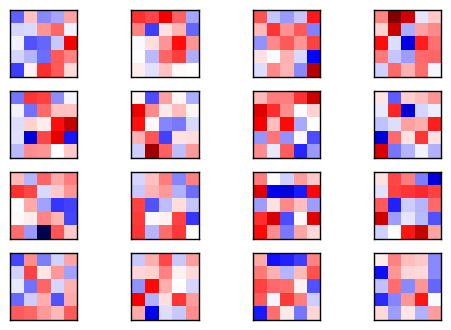

In [43]:
plot_conv_weights(weights=weights_conv1)

## Perform 10,000 optimization iterations

10000 번을 수행하지만, 1000번 학습 동안 검증 데이터셋에서 향상을 발견하지 못한다면, 최적화를 끝낸다.

`*` 은 분류 정확도가 향상되었는지 아닌지를 보여준다.

In [44]:
optimize(num_iterations=10000)

반복횟수:    100, 학습 배치 정확도:  84.4%, 검증 정확도:  84.0% *
반복횟수:    200, 학습 배치 정확도:  87.5%, 검증 정확도:  90.8% *
반복횟수:    300, 학습 배치 정확도:  92.2%, 검증 정확도:  93.3% *
반복횟수:    400, 학습 배치 정확도:  95.3%, 검증 정확도:  94.6% *
반복횟수:    500, 학습 배치 정확도:  98.4%, 검증 정확도:  94.4% 
반복횟수:    600, 학습 배치 정확도:  96.9%, 검증 정확도:  94.7% *
반복횟수:    700, 학습 배치 정확도:  96.9%, 검증 정확도:  95.7% *
반복횟수:    800, 학습 배치 정확도: 100.0%, 검증 정확도:  95.9% *
반복횟수:    900, 학습 배치 정확도:  92.2%, 검증 정확도:  96.5% *
반복횟수:   1000, 학습 배치 정확도:  96.9%, 검증 정확도:  96.6% *
반복횟수:   1100, 학습 배치 정확도:  96.9%, 검증 정확도:  96.2% 
반복횟수:   1200, 학습 배치 정확도:  95.3%, 검증 정확도:  96.8% *
반복횟수:   1300, 학습 배치 정확도:  93.8%, 검증 정확도:  97.2% *
반복횟수:   1400, 학습 배치 정확도:  98.4%, 검증 정확도:  97.5% *
반복횟수:   1500, 학습 배치 정확도: 100.0%, 검증 정확도:  97.3% 
반복횟수:   1600, 학습 배치 정확도:  98.4%, 검증 정확도:  97.6% *
반복횟수:   1700, 학습 배치 정확도:  96.9%, 검증 정확도:  97.3% 
반복횟수:   1800, 학습 배치 정확도:  98.4%, 검증 정확도:  97.7% *
반복횟수:   1900, 학습 배치 정확도: 100.0%, 검증 정확도:  97.7% 
반복횟수:   2000, 학습 배치 정확도:  95.3%, 검증 정확도:  97.8% *
반복횟수:

테스트셋에 대한 정확도: 98.5% (9846 / 10000)
Example errors:
Confusion Matrix:
[[ 977    0    0    0    0    0    0    2    1    0]
 [   0 1133    1    0    0    0    0    0    1    0]
 [   7    2 1011    1    1    0    0    4    6    0]
 [   2    0    1  990    0    9    0    4    4    0]
 [   1    0    0    0  975    0    0    0    1    5]
 [   2    0    0    4    0  880    1    2    1    2]
 [  15    3    0    1    6    6  923    0    4    0]
 [   0    0    9    2    0    0    0 1014    1    2]
 [   6    1    3    0    0    1    1    2  956    4]
 [   5    3    0    2    4    2    0    5    1  987]]


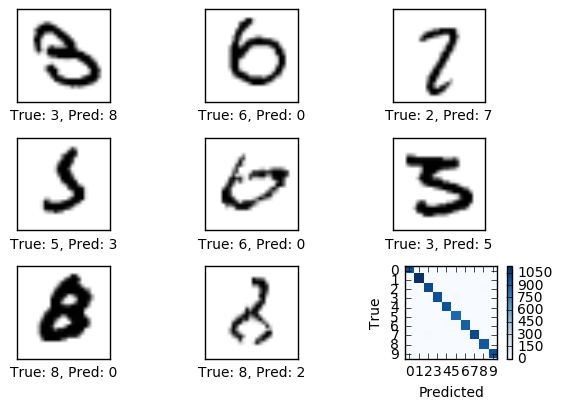

In [45]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

콘볼루션 가중치는 최적화되었다. 이들과 위의 무작위 가중치와 비교해보자. 거의 동일하다. 사실, 처음에 학습 전 후의 가중치가 동일하기 때문에 버그라고 생각했다.

하지만 이미지를 오른쪽으로 저장해서 두 이미지들을 비교하라. 최적화 전후의 약간의 차이를 볼 수 있을 것이다.

평균과 표준편차는 약간 변했으므로 최적화된 가중치는 달라야한다.

Mean: 0.03482, Stdev: 0.29179


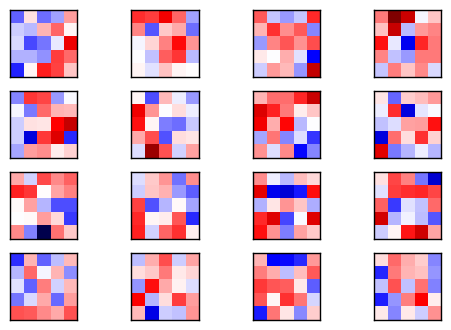

In [46]:
plot_conv_weights(weights=weights_conv1)

## Initialize Variables Again

신경망의 모든 변수들을 다시 초기화하자.

In [47]:
init_variables()

신경망이 이미지를 다시 완벽히 무작위로 분류하므로, 분류 정확도는 매우 안 좋다 왜냐하면 무작위 추측이기 때문이다.

In [48]:
print_test_accuracy()

테스트셋에 대한 정확도: 9.6% (957 / 10000)


콘볼루션 가중치는 위에서 본 가중치와 약간 다를 것이다.

Mean: -0.00122, Stdev: 0.28915


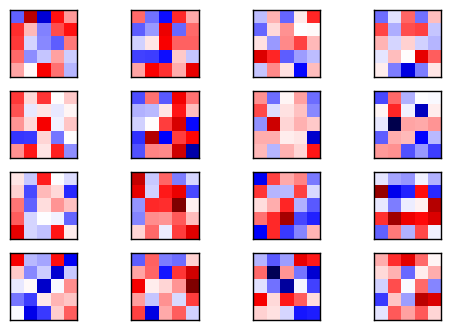

In [49]:
plot_conv_weights(weights=weights_conv1)

## Restore Best Variables

최적화 동안 파일에 저장되었던 모든 변수들을 불러오자

In [50]:
saver.restore(sess=session, save_path=save_path)

이전 저장된 변수들을 사용할 때 처럼 분류 정확도는 다시 높다

분류 정확도가 위에 기록된 것보다 약간 높거나 낮을 수도 있다. 왜냐하면 파일에 변수들은 검증 데이터셋에 대한 분류 정확도를 최대화한 것을 선택한 것이기 때문이다. 하지만 사실 이 최적화는 변수들을 저장한 후 1000번 반복되므로, 두개는 다를 수 있다. 때로 이것이 테스트세에 대해 더 높거나 낮은 성능을 이끌기도 한다.

테스트셋에 대한 정확도: 98.4% (9836 / 10000)
Example errors:
Confusion Matrix:
[[ 974    0    0    0    0    0    2    2    2    0]
 [   0 1127    2    1    0    0    2    1    2    0]
 [   5    2 1008    6    1    0    1    4    5    0]
 [   0    0    0 1005    0    3    0    1    1    0]
 [   1    0    0    0  973    0    1    2    2    3]
 [   2    0    1    6    0  876    2    2    1    2]
 [   2    2    0    1    2    5  946    0    0    0]
 [   0    0    8    5    0    0    0 1013    1    1]
 [   5    1    4   14    1    2    2    2  939    4]
 [   3    6    0    7    7    2    0    7    2  975]]


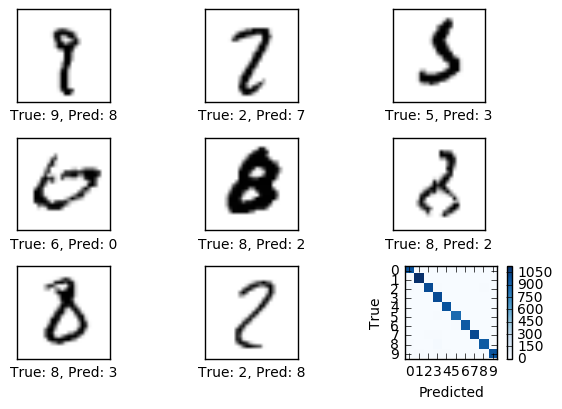

In [51]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

콘볼루션 가중치는 비록 완벽히 같지는 않더라도, 위에 나온 것과 거의 동일해야만 한다. 왜냐하면 위의 가중치들은 1000번 더 최적화 한 것이기 때문이다.

Mean: 0.03407, Stdev: 0.29001


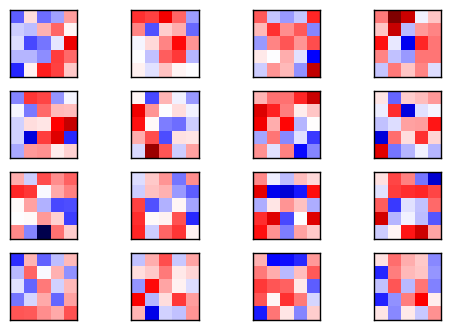

In [52]:
plot_conv_weights(weights=weights_conv1)

## Close TensorFlow Session

텐서플로 사용을 마쳤고, 리소스를 풀기 위해 세션을 닫는다.

In [53]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## Conclusion

이 튜토리얼은 신경망의 변수들을 저장하고 불러오는 방법을 보여준다. 이것은 다른 방식으로 사용할 수 있다. 예를 들어, 만약 이미지를 인식하기 위해 신경망을 사용하려면, 한번만 학습한 신경망을 다른 컴퓨터에 배포할 수 있다.

체크 포인트를 사용하는 또다른 방법은 매우 큰 데이터셋과 큰 신경망을 가지고 있는 경우, 컴퓨터 충돌에 대비해 정기적으로 체크포인트를 저장하고,  처음부터 다시 최적화는 대신에 최신 체크포인트로부터 최적화를 이어서 할 수 있다.

이 튜토링얼은 검증 오차가 향상되지 않으면 최적화를 끄태는 Early Stopping 이라 불리는 검증 데이터를 이용하는 방법을 보인다. 이것은 만약 신경망이 과적합되기 시작하고 학습데이터셋에 노이즈를 학습하기 시작한다면 유용하다; 비록 이 튜토리얼에서는 일어나지 않을 이슈라 하더라도.

흥미로운 점은 신경망의 성능이 무작위 추측으로부터 거의 완벽한 분류에 가까워짐에도 콘볼루션 가중치(혹은 필터)가 최적화로부터 약간 변하는 것이다. 무작위 가중치가 거의 충분하다는 것은 이상하게 보인다. 왜 이런 일이 생길까?

## Exercises

* 향상 없이 1000번 지나면 최적화는 멈춘다. 충분한가? Early Stopping 하는 더 좋은 방법이 있는가? 시도하고 구현하라
* 만약 체크포인트 파일이 이미 존재한다면 최적화 대신 불러와라.
* 매 100번 최적화 반복마다 새로운 checkpoint를 저장하라. `saver.latest_checkpoint()`를 사용해 최신것을 불러와라. 가장 최신 대신에 왜 여러개의 체크포인트를 저장하는가?
* 신경망을 바꾸고 시도하라, e.g. 다른 레이어를 추가하는 것처럼. 다른 신경망으로부터 변수들을 불러오면 무슨 일이 생기는가?
* `plot_conv_weights()`를 사용해 최적화 전 후의 2번째 콘볼루션 레이어에 대해 가중치를 그려라. 거의 동일한가?
* 왜 최적화된 콘볼루션 가중치가 무작위 초기화와 거의 동일하다고 생각하는가?
* 너무 많이 보지 말고 프로그램 다시 작성해보라.
* 친구에게 설명해보라

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.